# **Project:Pre-Processing & EDA**

**IMPORT LIBRARIES:**


## Installing Required Libraries

We start by installing all the necessary Python libraries for our bone tumor segmentation project. These include libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), image processing (opencv, pillow), deep learning (tensorflow), machine learning utilities (scikit-learn), and additional tools for data handling and progress tracking.

In [2]:
%pip install pandas numpy matplotlib seaborn opencv-python pillow tensorflow scikit-learn openpyxl tqdm

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl (12.6 MB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Libraries

We import a comprehensive set of libraries to support our bone tumor segmentation project:

1. **Data handling libraries**: os, json, pandas, numpy for file operations and data manipulation
2. **Visualization libraries**: matplotlib, seaborn for creating visualizations and plots
3. **Image processing libraries**: OpenCV, PIL for image loading, processing, and transformations
4. **Deep learning framework**: TensorFlow with Keras for building and training our segmentation models
5. **Machine learning utilities**: scikit-learn for data splitting, metrics calculation, and evaluation

These libraries provide the foundation for our image segmentation pipeline from data loading to model evaluation.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


import os
import math
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB2,DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

**PATH DEFINITIONS:**

## Path Configuration

We set up the file paths for our Bone Tumor X-Ray Dataset (BTXRD). This dataset contains:

1. X-ray images in JPEG format stored in the 'images' directory
2. Tumor annotations in JSON format stored in the 'Annotations' directory 
3. A comprehensive metadata Excel file with patient demographics and tumor classifications

These paths will be used throughout the notebook to access the dataset components.

In [3]:
# Path setup
BASE_DIR = "./"
IMG_DIR = os.path.join(BASE_DIR,"BTXRD", "images")
ANNOTATION_DIR = os.path.join(BASE_DIR,"BTXRD", "Annotations")
EXCEL_PATH = os.path.join(BASE_DIR, "BTXRD", "dataset.xlsx")

**LOAD METADATA:**

## Loading and Exploring Dataset Metadata

We load the metadata Excel file, which contains critical information about each X-ray image in the dataset. This includes:

1. Patient demographics (age, gender)
2. Anatomical location (body part affected)
3. Tumor classification (benign, malignant, normal)
4. Radiographic view (frontal, lateral, oblique)

Understanding this metadata is essential for preparing our segmentation dataset and interpreting results in a clinical context.

In [4]:
df = pd.read_excel(EXCEL_PATH)


df.head()

,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,fibula,femur,hip bone,ankle-joint,knee-joint,hip-joint,wrist-joint,elbow-joint,shoulder-joint,tumor,benign,malignant,osteochondroma,multiple osteochondromas,simple bone cyst,giant cell tumor,osteofibroma,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique
0,IMG000001.jpeg,1,48,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
1,IMG000002.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,IMG000003.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,IMG000004.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,IMG000005.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [5]:
df.shape

(3746, 37)

**CHECKING IMAGE SEGMENTATION & ANNOTATIONS:**

## Creating Target Labels and Validating Image Paths

In this step, we perform two important preprocessing operations:

1. **Label Creation**: We create a simplified 'label' column from multiple binary flags in the original data. Images are categorized as:
   - 'Normal' - No tumor present
   - 'Benign' - Non-cancerous tumor
   - 'Malignant' - Cancerous tumor

2. **Image Path Validation**: We create full image paths and verify that all images exist in the specified directory. This validation step is crucial before proceeding with image processing to ensure data integrity.

In [5]:
# Create target label
def get_label(row):
    if row['tumor'] == 0:
        return 'Normal'
    elif row['benign'] == 1:
        return 'Benign'
    elif row['malignant'] == 1:
        return 'Malignant'
    return 'Unknown'

df['label'] = df.apply(get_label, axis=1)

# Image path column
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMG_DIR,x))
df['image_exists'] = df['image_path'].apply(os.path.exists)

print("Missing images:", df['image_exists'].value_counts().get(False, 0))


Missing images: 0


In [7]:
df.head()

,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,fibula,femur,hip bone,ankle-joint,knee-joint,hip-joint,wrist-joint,elbow-joint,shoulder-joint,tumor,benign,malignant,osteochondroma,multiple osteochondromas,simple bone cyst,giant cell tumor,osteofibroma,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique,label,image_path,image_exists
0,IMG000001.jpeg,1,48,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,Malignant,./BTXRD\images\IMG000001.jpeg,True
1,IMG000002.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,Malignant,./BTXRD\images\IMG000002.jpeg,True
2,IMG000003.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,Malignant,./BTXRD\images\IMG000003.jpeg,True
3,IMG000004.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,Malignant,./BTXRD\images\IMG000004.jpeg,True
4,IMG000005.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,Malignant,./BTXRD\images\IMG000005.jpeg,True


## Visualizing Class Distribution

We visualize the distribution of tumor classes in our dataset to understand the class balance. This is an important consideration for model training, as imbalanced classes can bias the model's performance.

The visualization shows the count of images in each of the three classes: Normal, Benign, and Malignant. The class imbalance, particularly the lower proportion of malignant cases, reflects real-world clinical scenarios where malignant bone tumors are relatively rare compared to benign tumors and normal cases.

Text(0.5, 1.0, 'Class Distribution')

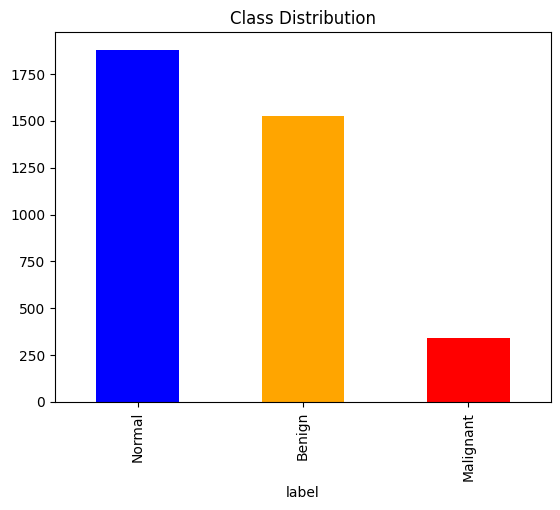

In [6]:
df['label'].value_counts().plot(kind='bar', color=['blue', 'orange', 'red'])
plt.title('Class Distribution')

In [30]:
# df[df['label']=='Normal']

**GENDER BASED CLASS DISTRIBUTION:**

## Analyzing Gender Distribution by Tumor Type

We analyze the gender distribution across different tumor types to identify any potential correlations or biases in our dataset. This demographic analysis helps us understand:

1. The representation of each gender within tumor classes
2. The percentage of each gender-tumor combination in the overall dataset

This information is valuable for ensuring model fairness across demographic groups and for interpreting potential biases in model predictions based on gender representation in the training data.

In [7]:
counts = df.groupby(['label','gender']).size().reset_index(name='count')
counts['gender_percentage'] = (counts['count']/len(df)*100)

counts

,label,gender,count,gender_percentage
0,Benign,F,630,16.817939
1,Benign,M,895,23.892152
2,Malignant,F,162,4.324613
3,Malignant,M,180,4.805125
4,Normal,F,856,22.851041
5,Normal,M,1023,27.309130


**CLASS DISTRIBUTION | AGE BASED TUMOR DISTRIBUTION | AGE BASED:**

## Comprehensive Demographic Analysis

This section provides a comprehensive visual analysis of the dataset demographics across three key dimensions:

1. **Tumor Type Distribution**: A count plot showing the distribution of Normal, Benign, and Malignant cases, reinforcing our understanding of class imbalance

2. **Age Distribution by Tumor Type**: A histogram showing how tumor types are distributed across different age groups. This reveals important clinical patterns, such as the higher incidence of malignant tumors in younger patients

3. **Gender Distribution by Tumor Type**: A comparative visualization of tumor types across genders to identify any gender-specific patterns in tumor occurrence

These demographic insights are essential for understanding the clinical context of our dataset and potential factors that might influence model performance.

/var/folders/jn/h9tbpzj15bd9brq3yl_wpbc80000gp/T/ipykernel_80777/1429553412.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='mako')


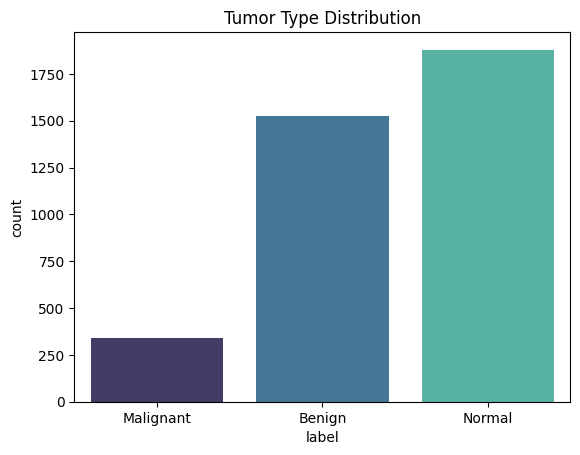

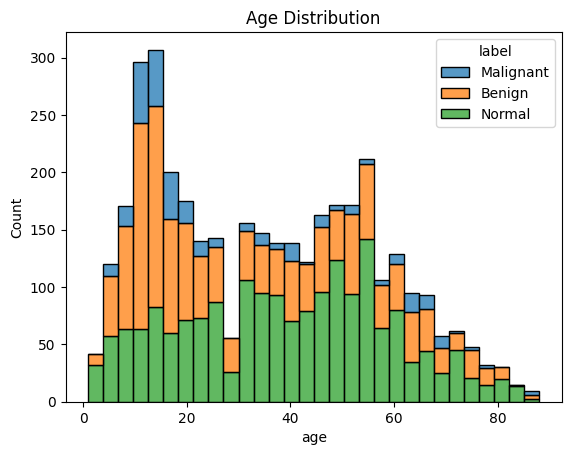

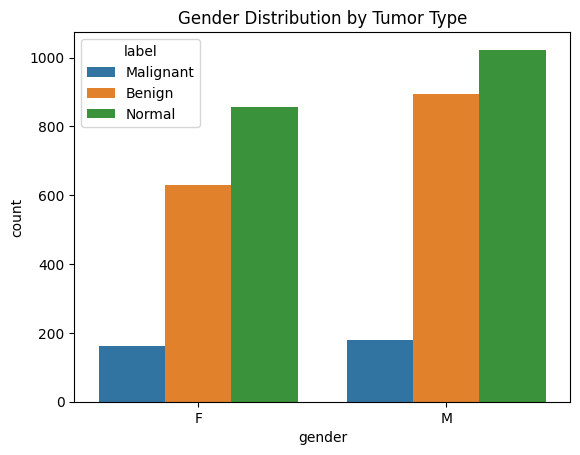

In [8]:
sns.countplot(data=df, x='label', palette='mako')
plt.title("Tumor Type Distribution")
plt.show()

sns.histplot(data=df, x='age', hue='label', bins=30, multiple='stack')
plt.title("Age Distribution")
plt.show()

sns.countplot(data=df, x='gender', hue='label')
plt.title("Gender Distribution by Tumor Type")
plt.show()


**BOADY PART ANALYSIS:**

## Body Part Analysis

This analysis examines the distribution of affected body parts in the dataset. Understanding the anatomical distribution is crucial for segmentation tasks because:

1. Different bones have distinct shapes, densities, and surrounding tissue contexts
2. Tumors in different anatomical regions manifest with varying radiographic features
3. X-rays from different body parts have different standard views and positioning

The visualization shows that tibia, femur, and hip bone are the most commonly affected sites. This anatomical heterogeneity presents a significant challenge for the segmentation model, which must generalize across these variations in bone structure and tumor presentation.

/var/folders/jn/h9tbpzj15bd9brq3yl_wpbc80000gp/T/ipykernel_80777/1010165833.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=body_counts.index, y=body_counts.values, palette='viridis')


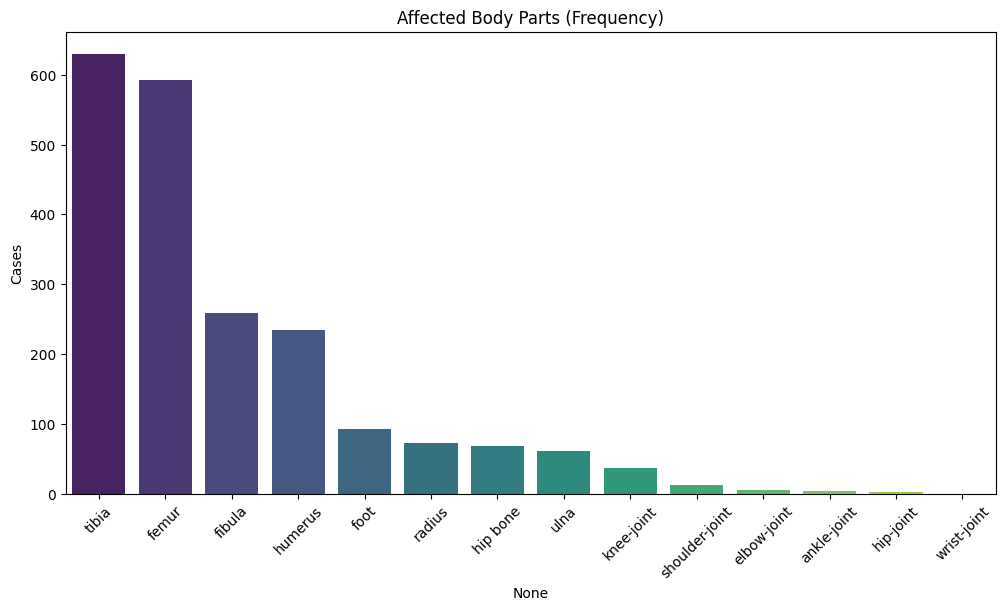

In [9]:
body_part_cols = [
    'ulna', 'radius', 'humerus', 'foot', 'tibia', 'fibula',
    'femur', 'hip bone', 'ankle-joint', 'knee-joint', 'hip-joint',
    'wrist-joint', 'elbow-joint', 'shoulder-joint'
]

body_counts = df[body_part_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=body_counts.index, y=body_counts.values, palette='viridis')
plt.title("Affected Body Parts (Frequency)")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()


**SAMPLE X-RAY VIEWER:**

## X-Ray Image Viewer

We create a function to display X-ray images from our dataset. This allows us to visually inspect the images and understand their characteristics. The function:

1. Takes an index from the DataFrame
2. Loads the corresponding X-ray image using OpenCV
3. Displays the image with its ID and tumor classification label

Visual inspection of these images helps us understand the radiographic appearance of different tumor types and the image quality in our dataset. This is essential for designing appropriate preprocessing steps and interpreting model performance.

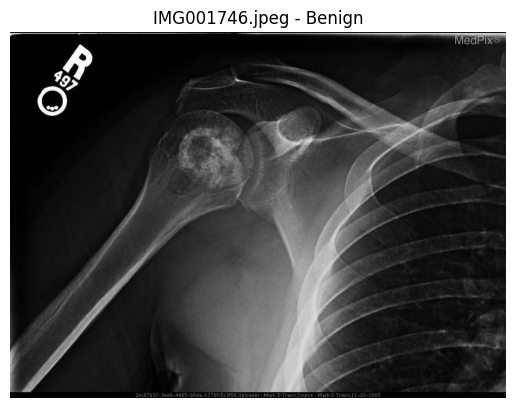

In [10]:
def show_xray(idx):
    row = df.iloc[idx]
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        plt.imshow(img, cmap='gray')
        plt.title(f"{row['image_id']} - {row['label']}")
        plt.axis('off')
        plt.show()
    else:
        print("Image not found.")

# Random sample
show_xray(df[df['label'] != 'Unknown'].sample(969).index[0])


**PARSE ANNOTATIONS:**

## Annotation Loading Utilities

These utility functions are essential for working with the tumor annotations in our dataset:

1. **load_annotation**: Loads JSON annotation files for a given image ID. These annotations contain precise tumor boundary information in the form of polygons or rectangles

2. **_to_int_tuple**: Converts coordinate points from the JSON format to integer tuples that can be used for drawing on images

These functions provide the foundation for accessing and processing the ground truth segmentation masks that will be used for training and evaluating our segmentation models.

In [41]:
# Cell 1
def load_annotation(image_id):
    json_path = os.path.join(ANNOTATION_DIR, f"{image_id}.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            return json.load(f)
    return None

def _to_int_tuple(pt):
    return tuple(int(round(v)) for v in pt)

## Annotation Visualization

This function visualizes tumor annotations on X-ray images, allowing us to see how tumors are delineated in the dataset. The function:

1. Loads the original X-ray image and its corresponding annotation file
2. Draws rectangles or polygons based on the annotation shape type
3. Labels the tumor regions with their classification type

Visualizing these annotations helps us understand the annotation quality, tumor shapes, and sizes. This information is crucial for designing appropriate segmentation algorithms and evaluating their performance against ground truth annotations.

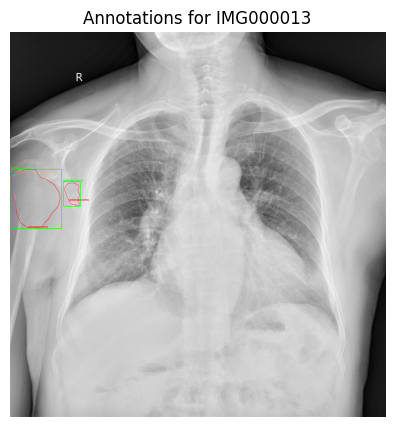

In [42]:

def draw_annotation(image_id_or_row, h=12, w = 12):
    # Accept either image_id string or df row with image_path
    if isinstance(image_id_or_row, str):
        image_id = image_id_or_row
        ann = load_annotation(image_id)
        if not ann:
            print(f"No annotation found for {image_id}")
            return
        img_path = os.path.join(IMG_DIR, ann.get('imagePath', f"{image_id}.jpeg"))
    else:
        row = image_id_or_row
        image_id = row["image_id_clean"] if "image_id_clean" in row else os.path.splitext(row["image_id"])[0]
        ann = load_annotation(image_id)
        img_path = row["image_path"] if "image_path" in row else os.path.join(IMG_DIR, row["image_id"])

    img = cv2.imread(img_path)
    if img is None:
        print("Could not read", img_path)
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if ann:
        for shape in ann.get('shapes', []):
            label = shape.get('label', 'tumor')
            pts = shape.get('points', [])
            st = shape.get('shape_type', 'polygon')
            if st == 'rectangle' and len(pts) >= 2:
                x1,y1 = _to_int_tuple(pts[0])
                x2,y2 = _to_int_tuple(pts[1])
                x_min, x_max = min(x1,x2), max(x1,x2)
                y_min, y_max = min(y1,y2), max(y1,y2)
                cv2.rectangle(img, (x_min,y_min), (x_max,y_max), (0,255,0), 3)
                cv2.putText(img, label, (x_min, max(0,y_min-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
            elif st in ('polygon','polyline') and len(pts) >= 3:
                polygon = np.array([_to_int_tuple(p) for p in pts], dtype=np.int32).reshape((-1,1,2))
                cv2.polylines(img, [polygon], isClosed=True, color=(255,0,0), thickness=2)
                cv2.putText(img, label, _to_int_tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    plt.figure(figsize=(h, w))
    plt.imshow(img); plt.axis('off'); plt.title(f"Annotations for {image_id}")
    plt.show()

# Example:
draw_annotation('IMG000013', 5, 5)

**TUMOR AREA %:**

## Tumor Area Analysis

This section analyzes the percentage of image area occupied by tumor regions. This analysis is critical for understanding:

1. The extent of class imbalance at the pixel level (tumor vs. background pixels)
2. The typical size of tumor regions relative to the entire X-ray image
3. The distribution of tumor sizes across different cases

This information helps us design appropriate loss functions and sampling strategies to address the severe class imbalance typical in medical image segmentation tasks, where the region of interest often occupies only a small fraction of the total image area.

In [13]:
# TUMOR AREA ANALYSIS (EDA)

from tqdm import tqdm
import glob


annotation_files = glob.glob(os.path.join(ANNOTATION_DIR, "*.json"))
annotated_ids = [os.path.splitext(os.path.basename(f))[0] for f in annotation_files]


df['image_id_clean'] = df['image_id'].astype(str).str.replace('.jpeg', '', case=False).str.strip()
df['image_id_clean'] = df['image_id_clean'].astype(str).str.replace('.jpg', '', case=False).str.strip()


df_annotated = df[df['image_id_clean'].isin(annotated_ids)].copy()
print(f"Annotated entries: {df_annotated.shape[0]}")


def calculate_tumor_area_percentage(ann):
    width = ann['imageWidth']
    height = ann['imageHeight']
    image_area = width * height

    total_area = 0
    for shape in ann['shapes']:
        pts = shape['points']
        if shape['shape_type'] == 'rectangle':
            (x1, y1), (x2, y2) = pts
            total_area += abs((x2 - x1) * (y2 - y1))
        elif shape['shape_type'] == 'polygon':
            pts = np.array(pts)
            x = pts[:, 0]
            y = pts[:, 1]
            total_area += 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    return 100 * total_area / image_area

def compute_tumor_area_column(df_subset):
    area_list = []
    for image_id in tqdm(df_subset['image_id_clean']):
        ann = load_annotation(image_id)
        if ann:
            try:
                area_pct = calculate_tumor_area_percentage(ann)
            except Exception as e:
                print(f"Error in {image_id}: {e}")
                area_pct = np.nan
        else:
            area_pct = np.nan
        area_list.append(area_pct)

    df_subset['tumor_area_pct'] = area_list
    return df_subset

df_annotated = compute_tumor_area_column(df_annotated)


Annotated entries: 1867


100%|██████████| 1867/1867 [00:02<00:00, 687.97it/s]


In [14]:
df['image_id_clean'].head()

0    IMG000001
1    IMG000002
2    IMG000003
3    IMG000004
4    IMG000005
Name: image_id_clean, dtype: object

In [15]:
'IMG000473'
df[df['image_id_clean'] == 'IMG003734']

,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,fibula,femur,hip bone,ankle-joint,knee-joint,hip-joint,wrist-joint,elbow-joint,shoulder-joint,tumor,benign,malignant,osteochondroma,multiple osteochondromas,simple bone cyst,giant cell tumor,osteofibroma,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique,label,image_path,image_exists,image_id_clean
3733,IMG003734.jpg,3,30,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,Normal,./BTXRD/images/IMG003734.jpg,True,IMG003734


In [16]:
import os
import json
import csv
from PIL import Image

# --- CONFIG ---
ANNOTATIONS_DIR = "BTXRD/Annotations"
IMAGES_DIR = "BTXRD/images"
OUTPUT_CSV = "dataset_object_detection.csv"
BUCKET_NAME = "bone-cancer-bucket"
# df is already loaded
# ----------------

def points_to_box(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    return min(xs), min(ys), max(xs), max(ys)

def normalize(val, max_val):
    return max(0.0, min(1.0, val / max_val))

# Generate Masked image 

## Mask Generation

This section generates binary masks from the tumor annotations. These masks will serve as the ground truth for training our segmentation models. The process involves:

1. Loading JSON annotation files containing tumor boundary coordinates
2. Creating empty binary masks with the same dimensions as the original images
3. Drawing filled polygons or rectangles on the masks based on the annotation coordinates
4. Saving the generated masks for later use in model training

This conversion from vector annotations to binary masks is a crucial preprocessing step for supervised training of segmentation models.

In [27]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Paths
ANNOTATIONS_DIR = "BTXRD/Annotations"
IMAGES_DIR = "BTXRD/images"
MASKS_DIR = "BTXRD/masks"  # Save generated masks here
os.makedirs(MASKS_DIR, exist_ok=True)

BUCKET_NAME = "bone-cancer-bucket"
GCS_IMAGE_PREFIX = f"gs://{BUCKET_NAME}/images/"
GCS_MASK_PREFIX = f"gs://{BUCKET_NAME}/masks/"

# Helper: Draw mask from LabelMe shapes
def create_mask_from_json(json_path, mask_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    w, h = data["imageWidth"], data["imageHeight"]
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)
    for shape in data.get("shapes", []):
        if shape["shape_type"] == "polygon":
            points = [tuple(p) for p in shape["points"]]
            draw.polygon(points, fill=255)
    mask.save(mask_path)

# --- SPLIT DATA ---
# Only keep rows with both annotation and image present
valid_rows = []
for idx, row in df.iterrows():
    image_id = row['image_id_clean']
    json_path = os.path.join(ANNOTATIONS_DIR, f"{image_id}.json")
    img_name = row['image_id']
    img_path = os.path.join(IMAGES_DIR, img_name)
    if os.path.exists(json_path) and os.path.exists(img_path):
        valid_rows.append(row)

df_valid = pd.DataFrame(valid_rows)

# Split into train, val, test (e.g., 70/15/15)
train_df, temp_df = train_test_split(df_valid, test_size=0.3, random_state=42, stratify=df_valid['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

split_map = {}
for idx in train_df.index:
    split_map[idx] = "TRAIN"
for idx in val_df.index:
    split_map[idx] = "VALIDATION"
for idx in test_df.index:
    split_map[idx] = "TEST"

# Process all JSONs and create masks/CSV rows
rows = []
for idx, row in df_valid.iterrows():
    image_id = row['image_id_clean']
    json_path = os.path.join(ANNOTATIONS_DIR, f"{image_id}.json")
    img_name = row['image_id']
    img_path = os.path.join(IMAGES_DIR, img_name)
    mask_name = image_id + "_mask.png"
    mask_path = os.path.join(MASKS_DIR, mask_name)

    # Create mask
    create_mask_from_json(json_path, mask_path)

    # GCS paths
    gcs_img = GCS_IMAGE_PREFIX + img_name
    gcs_mask = GCS_MASK_PREFIX + mask_name

    split = split_map[idx]
    rows.append([gcs_img, gcs_mask, split])

# Save CSV
df_mask = pd.DataFrame(rows, columns=["GCS_FILE_PATH", "MASK_GCS_FILE_PATH", "DATASET_SPLIT"])
df_mask.to_csv("vertexai_segmentation.csv", index=False)
print("CSV created: vertexai_segmentation.csv with train/val/test split.")

CSV created: vertexai_segmentation.csv with train/val/test split.


## Loading Image-Mask Pairs

This function loads pairs of X-ray images and their corresponding segmentation masks for model training. Key features include:

1. Support for both tumor-containing and normal images (where masks are empty)
2. Resizing all images and masks to a standard input size (224×224 pixels)
3. Normalization of pixel values to the [0,1] range for better training convergence
4. Proper handling of binary masks by thresholding at 127 (half of 255)

This function creates the input-output pairs needed for supervised training of our segmentation models, with X representing the input images and Y representing the target segmentation masks.

In [31]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm

IMG_DIR = "BTXRD/images"
MASK_DIR = "BTXRD/masks"
IMG_SIZE = 224

def load_image_mask_pairs_with_empty(img_dir, mask_dir, img_size=224):
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    X, Y = [], []
    for img_file in tqdm(img_files):
        base = os.path.splitext(img_file)[0]
        mask_file = base + "_mask.png"
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        img = Image.open(img_path).convert("RGB").resize((img_size, img_size))
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L").resize((img_size, img_size))
            mask_arr = (np.array(mask) > 127).astype(np.float32)
        else:
            mask_arr = np.zeros((img_size, img_size), dtype=np.float32)
        X.append(np.array(img) / 255.0)
        Y.append(mask_arr)
    X = np.array(X, dtype=np.float32)
    Y = np.expand_dims(np.array(Y, dtype=np.float32), axis=-1)
    return X, Y

X, Y = load_image_mask_pairs_with_empty(IMG_DIR, MASK_DIR, IMG_SIZE)
print(f"Loaded {X.shape[0]} image-mask pairs (including empty masks for non-tumor images).")

100%|██████████| 3746/3746 [01:02<00:00, 59.62it/s]


Loaded 3746 image-mask pairs (including empty masks for non-tumor images).


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Basic U-Net Segmentation Model

We now define the basic U-Net architecture for bone tumor segmentation. U-Net is a convolutional neural network architecture designed specifically for biomedical image segmentation. Its key features include:

1. **Encoder-Decoder Structure**: Captures context and enables precise localization
2. **Skip Connections**: Combines low-level feature maps with higher-level ones, preserving spatial information
3. **Symmetric Architecture**: Similar number of layers in encoder and decoder paths

This architecture was chosen for its proven effectiveness in medical image segmentation tasks with limited training data. The model takes X-ray images as input and produces pixel-wise segmentation masks identifying tumor regions.

# Train Test Split

## Train-Test Split and Model Definition

In this section, we:

1. Split our dataset into training and validation sets (80/20 split) to properly evaluate model performance
2. Define the basic U-Net architecture, which consists of:
   - An encoder path with 3 blocks of convolution and max pooling layers
   - A bottleneck with 2 convolutional layers
   - A decoder path with 3 blocks of upsampling and convolution layers
   - Skip connections between corresponding encoder and decoder levels
   - A final 1×1 convolution with sigmoid activation for binary mask prediction

This architecture is designed to effectively capture both local and global features in X-ray images for accurate tumor segmentation.

In [32]:
# --- TRAIN/VAL SPLIT ---
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- SIMPLE U-NET MODEL ---
def build_unet(input_shape=(224,224,3)):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)
    # Bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)
    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)
    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)
    u1 = layers.UpSampling2D()(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(c6)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)
    model = models.Model(inputs, outputs)
    return model

model = build_unet((IMG_SIZE, IMG_SIZE, 3))

## Model Compilation

We compile the U-Net model by specifying:

1. **Optimizer**: Adam optimizer, which adapts the learning rate for each parameter
2. **Loss Function**: Binary cross-entropy, appropriate for binary segmentation tasks
3. **Metrics**: Accuracy, though it has limitations for imbalanced segmentation problems

The model summary provides a detailed view of the network architecture, showing the output shape and number of parameters for each layer. This gives us insight into the model's complexity and memory requirements.

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 56, 56,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 56, 56,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 56, 56,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 112, 112,  │          0 │ conv2d_24[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training Configuration

Before training the model, we set up important callbacks to optimize the training process:

1. **ModelCheckpoint**: Saves the best model based on validation loss during training
2. **EarlyStopping**: Prevents overfitting by stopping training when validation loss stops improving

These callbacks help ensure that we save the most generalizable model and avoid wasting computational resources on training that no longer improves performance.

In [34]:
# Save best model during training
checkpoint_cb = ModelCheckpoint('best_unet_segmentation.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9881 - loss: 0.1215
Epoch 1: val_loss improved from None to 0.05450, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 100s 260ms/step - accuracy: 0.9879 - loss: 0.0733 - val_accuracy: 0.9890 - val_loss: 0.0545
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9886 - loss: 0.0564
Epoch 2: val_loss improved from 0.05450 to 0.05023, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 396ms/step - accuracy: 0.9881 - loss: 0.0580 - val_accuracy: 0.9890 - val_loss: 0.0502
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9887 - loss: 0.0539
Epoch 3: val_loss did not improve from 0.05023
375/375 ━━━━━━━━━━━━━━━━━━━━ 136s 363ms/step - accuracy: 0.9881 - loss: 0.0558 - val_accuracy: 0.9890 - val_loss: 0.0533
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9876 - loss: 0.0570
Epoch 4: val_loss improved from 0.05023 to 0.04927, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 342ms/step - accuracy: 0.9881 - loss: 0.0550 - val_accuracy: 0.9890 - val_loss: 0.0493
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9882 - loss: 0.0542
Epoch 5: val_loss did not improve from 0.04927
375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 339ms/step - accuracy: 0.9881 - loss: 0.0547 - val_accuracy: 0.9890 - val_loss: 0.0506
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9887 - loss: 0.0514
Epoch 6: val_loss did not improve from 0.04927
375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 335ms/step - accuracy: 0.9881 - loss: 0.0538 - val_accuracy: 0.9890 - val_loss: 0.0543
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9886 - loss: 0.0506
Epoch 9: val_loss improved from 0.04927 to 0.04788, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 130s 346ms/step - accuracy: 0.9881 - loss: 0.0524 - val_accuracy: 0.9890 - val_loss: 0.0479
Epoch 10/20
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9882 - loss: 0.0526
Epoch 10: val_loss did not improve from 0.04788
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 341ms/step - accuracy: 0.9881 - loss: 0.0530 - val_accuracy: 0.9890 - val_loss: 0.0485
Epoch 11/20

Epoch 10: val_loss did not improve from 0.04788
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 341ms/step - accuracy: 0.9881 - loss: 0.0530 - val_accuracy: 0.9890 - val_loss: 0.0485
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9887 - loss: 0.0505
Epoch 11: val_loss improved from 0.04788 to 0.04708, saving model to best_unet_segmentation.h5

Epoch 11: val_loss improved from 0.04788 to 0.04708, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 129s 343ms/step - accuracy: 0.9881 - loss: 0.0525 - val_accuracy: 0.9890 - val_loss: 0.0471
Epoch 12/20
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9881 - loss: 0.0523
Epoch 12: val_loss did not improve from 0.04708
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 341ms/step - accuracy: 0.9881 - loss: 0.0519 - val_accuracy: 0.9890 - val_loss: 0.0513
Epoch 13/20

Epoch 12: val_loss did not improve from 0.04708
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 341ms/step - accuracy: 0.9881 - loss: 0.0519 - val_accuracy: 0.9890 - val_loss: 0.0513
Epoch 13/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9879 - loss: 0.0524
Epoch 13: val_loss improved from 0.04708 to 0.04703, saving model to best_unet_segmentation.h5

Epoch 13: val_loss improved from 0.04708 to 0.04703, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 339ms/step - accuracy: 0.9881 - loss: 0.0515 - val_accuracy: 0.9890 - val_loss: 0.0470
Epoch 14/20
Epoch 14/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9874 - loss: 0.0530
Epoch 14: val_loss did not improve from 0.04703
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 340ms/step - accuracy: 0.9881 - loss: 0.0513 - val_accuracy: 0.9890 - val_loss: 0.0474
Epoch 15/20

Epoch 14: val_loss did not improve from 0.04703
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 340ms/step - accuracy: 0.9881 - loss: 0.0513 - val_accuracy: 0.9890 - val_loss: 0.0474
Epoch 15/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9884 - loss: 0.0496
Epoch 15: val_loss did not improve from 0.04703
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 349ms/step - accuracy: 0.9881 - loss: 0.0504 - val_accuracy: 0.9890 - val_loss: 0.0472
Epoch 16/20

Epoch 15: val_loss did not improve from 0.04703
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 349ms/step - accuracy: 0.9881 - loss: 0.0504 - val_accuracy: 0.9890 - val_

375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 349ms/step - accuracy: 0.9881 - loss: 0.0497 - val_accuracy: 0.9890 - val_loss: 0.0461
Epoch 17/20
Epoch 17/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9889 - loss: 0.0466
Epoch 17: val_loss did not improve from 0.04613
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 350ms/step - accuracy: 0.9881 - loss: 0.0493 - val_accuracy: 0.9890 - val_loss: 0.0464
Epoch 18/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9877 - loss: 0.0487
Epoch 18: val_loss improved from 0.04613 to 0.04428, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 129s 343ms/step - accuracy: 0.9881 - loss: 0.0477 - val_accuracy: 0.9890 - val_loss: 0.0443
Epoch 19/20
Epoch 19/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9878 - loss: 0.0474
Epoch 19: val_loss improved from 0.04428 to 0.04367, saving model to best_unet_segmentation.h5

Epoch 19: val_loss improved from 0.04428 to 0.04367, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 129s 345ms/step - accuracy: 0.9881 - loss: 0.0472 - val_accuracy: 0.9890 - val_loss: 0.0437
Epoch 20/20
Epoch 20/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9878 - loss: 0.0465
Epoch 20: val_loss improved from 0.04367 to 0.04133, saving model to best_unet_segmentation.h5

Epoch 20: val_loss improved from 0.04367 to 0.04133, saving model to best_unet_segmentation.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 342ms/step - accuracy: 0.9881 - loss: 0.0451 - val_accuracy: 0.9890 - val_loss: 0.0413
Restoring model weights from the end of the best epoch: 20.
Restoring model weights from the end of the best epoch: 20.


In [111]:
# Save the trained model in Keras format
model.save('unet_tumor_segmentation.keras')
print("Model saved as unet_tumor_segmentation.keras")

Model saved as unet_tumor_segmentation.keras


In [112]:

# --- SEGMENTATION METRICS ---
def iou_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def dice_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2. * intersection / (y_true.sum() + y_pred.sum() + 1e-7)

# Evaluate on validation set
ious, dices = [], []
for i in range(len(X_val)):
    pred = (model.predict(X_val[i][None])[0].squeeze() > 0.5).astype(np.uint8)
    true = Y_val[i].squeeze().astype(np.uint8)
    ious.append(iou_score(true, pred))
    dices.append(dice_score(true, pred))
print(f"Mean IoU: {np.mean(ious):.3f}, Mean Dice: {np.mean(dices):.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━

# Model Evaluation Metrics and Visualizations

This section evaluates the segmentation model using Dice Similarity Coefficient, Intersection over Union (IoU), Sensitivity, Hausdorff Distance, F1-score, ROC curve, and plots for loss and accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Dice: 0.000
Mean IoU: 0.505
Mean Sensitivity: 0.000
Mean Hausdorff Distance: nan
Mean F1-score: 0.000


/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rahsan/rakib/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/var/folders/jn/h9tbpzj15bd9brq3yl_wpbc80000gp/T/ipykernel_80777/2232774279.py:52: RuntimeWarning: Mean of empty slice
  print(f"Mean Hausdorff Distance: {np.nanmean(hds):.3f}")


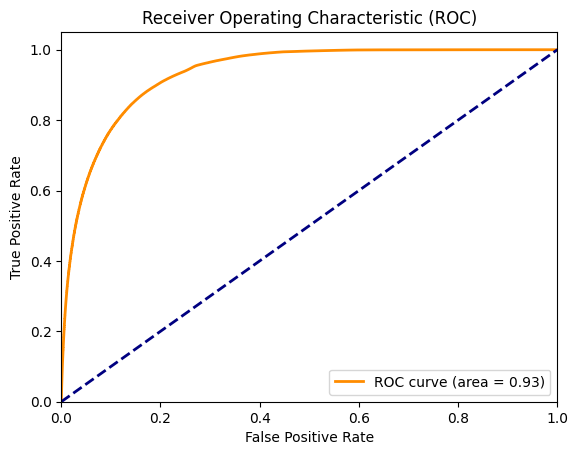

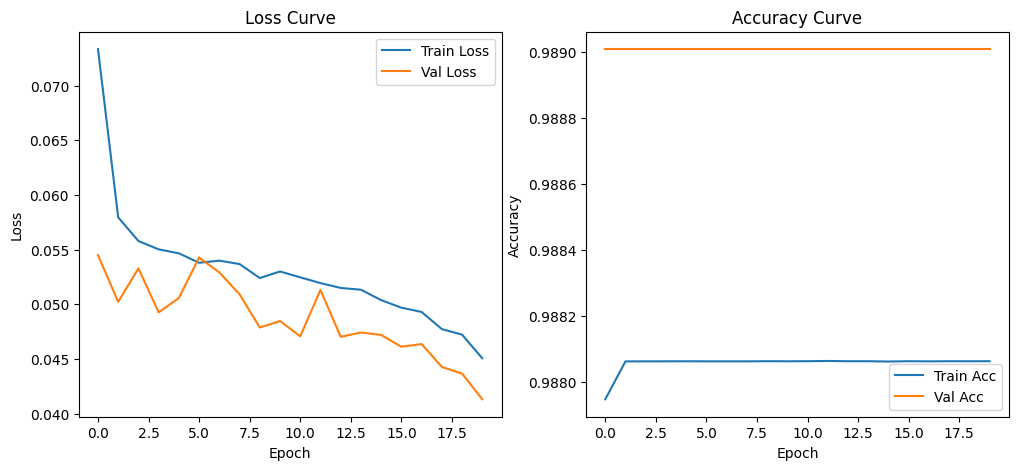

In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, recall_score
from scipy.spatial.distance import directed_hausdorff

# Helper functions

def dice_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2. * intersection / (y_true.sum() + y_pred.sum() + 1e-7)

def iou_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def sensitivity(y_true, y_pred):
    # Sensitivity = TP / (TP + FN)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return recall_score(y_true, y_pred)

def hausdorff_distance(y_true, y_pred):
    # Compute Hausdorff Distance between two binary masks
    true_pts = np.argwhere(y_true)
    pred_pts = np.argwhere(y_pred)
    if len(true_pts) == 0 or len(pred_pts) == 0:
        return np.nan
    hd1 = directed_hausdorff(true_pts, pred_pts)[0]
    hd2 = directed_hausdorff(pred_pts, true_pts)[0]
    return max(hd1, hd2)

ious, dices, sens, hds, f1s, y_true_all, y_pred_all, y_prob_all = [], [], [], [], [], [], [], []
for i in range(len(X_val)):
    y_true = Y_val[i].squeeze().astype(np.uint8)
    y_prob = model.predict(X_val[i][None])[0].squeeze()
    y_pred = (y_prob > 0.5).astype(np.uint8)
    ious.append(iou_score(y_true, y_pred))
    dices.append(dice_score(y_true, y_pred))
    sens.append(sensitivity(y_true, y_pred))
    hds.append(hausdorff_distance(y_true, y_pred))
    f1s.append(f1_score(y_true.flatten(), y_pred.flatten(), zero_division=0))
    y_true_all.extend(y_true.flatten())
    y_pred_all.extend(y_pred.flatten())
    y_prob_all.extend(y_prob.flatten())

Mean Dice: 0.000
Mean IoU: 0.505
Mean Sensitivity: 0.000
Mean Hausdorff Distance: nan
Mean F1-score: 0.000


/var/folders/jn/h9tbpzj15bd9brq3yl_wpbc80000gp/T/ipykernel_80777/3748572306.py:4: RuntimeWarning: Mean of empty slice
  print(f"Mean Hausdorff Distance: {np.nanmean(hds):.3f}")


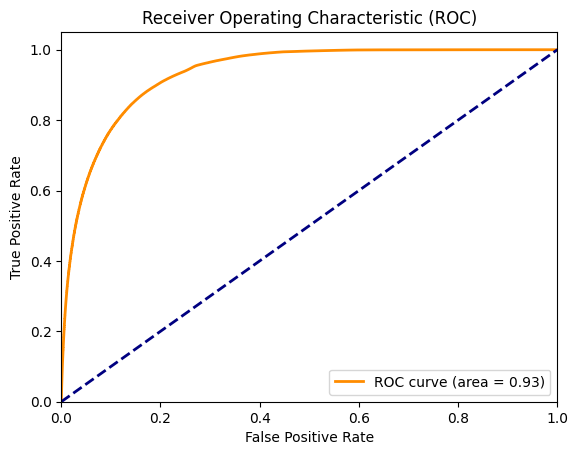

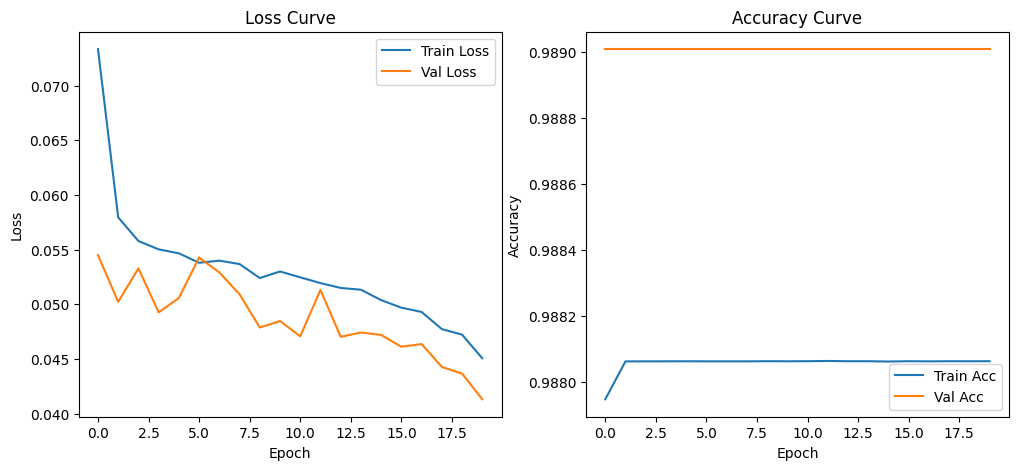

In [ ]:
print(f"Mean Dice: {np.nanmean(dices):.3f}")
print(f"Mean IoU: {np.nanmean(ious):.3f}")
print(f"Mean Sensitivity: {np.nanmean(sens):.3f}")
print(f"Mean Hausdorff Distance: {np.nanmean(hds):.3f}")
print(f"Mean F1-score: {np.nanmean(f1s):.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Loss and Accuracy Curves
if 'history' in locals():
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

- Mean Dice: 0.000
- Mean IoU: 0.505
- Mean Sensitivity: 0.000
- Mean Hausdorff Distance: nan
- Mean F1-score: 0.000

# Improved Segmentation Model Design

After evaluating the basic U-Net, we now design an improved segmentation model to address the limitations we observed. Key improvements include:

1. **Custom Loss Functions**:
   - Dice loss: Focuses on region overlap, less affected by class imbalance
   - Focal loss: Gives more weight to hard-to-classify examples
   - Combined loss: A weighted combination of both for optimal performance

2. **Data Augmentation**: Rotation, shifting, flipping, and zooming to increase effective dataset size

3. **Custom Metrics**: Tracking Dice coefficient and IoU during training for better model evaluation

These improvements are designed to address the severe class imbalance in our segmentation task, where tumor regions typically occupy less than 5% of the total image area.

## Improved Loss Functions and Data Augmentation

We implement specialized loss functions to address the class imbalance problem in tumor segmentation:

1. **Dice Loss**: Focuses on the overlap between predicted and ground truth regions, making it less sensitive to class imbalance
2. **Focal Loss**: Gives more weight to hard-to-classify examples, helping the model learn from challenging tumor cases
3. **Combined Loss**: Balances pixel-wise classification (focal loss) with region-based segmentation (dice loss)

Additionally, we create a data augmentation pipeline to increase the effective size of our training dataset through:
- Random rotations and shifts
- Horizontal and vertical flips
- Zoom variations

These techniques improve model generalization and help address the limited number of tumor examples.

In [117]:
# IMPROVED SEGMENTATION MODEL

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

# Custom loss functions for segmentation
def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice loss for segmentation"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal loss to handle class imbalance"""
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    
    # Calculate focal loss
    pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
    alpha_t = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
    focal_weight = alpha_t * K.pow(1 - pt, gamma)
    focal_loss = -focal_weight * K.log(pt)
    
    return K.mean(focal_loss)

def combined_loss(y_true, y_pred):
    """Combination of dice loss and focal loss"""
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient metric"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    """IoU metric"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Data augmentation
def create_augmented_generator(X_train, Y_train, batch_size=8):
    """Create data generator with augmentation"""
    data_gen_args = dict(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest'
    )
    
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    
    # Ensure same random state for image and mask
    seed = 42
    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(Y_train, batch_size=batch_size, seed=seed)
    
    def generator():
        while True:
            img_batch = next(image_generator)
            mask_batch = next(mask_generator)
            yield img_batch, mask_batch
    
    return generator()

print("Improved loss functions and data augmentation defined.")

Improved loss functions and data augmentation defined.


## Attention U-Net Architecture

We implement an improved U-Net architecture with attention gates. This advanced architecture includes:

1. **Attention Mechanism**: Helps the model focus on relevant regions by suppressing irrelevant features
2. **Batch Normalization**: Stabilizes and accelerates training
3. **Deeper Network**: More convolutional blocks for higher capacity
4. **Dropout Regularization**: Prevents overfitting by randomly deactivating neurons during training

The attention mechanism is particularly valuable for medical image segmentation as it helps the model focus on small, subtle tumor regions while ignoring irrelevant background structures.

In [118]:
# IMPROVED U-NET ARCHITECTURE

def attention_block(F_g, F_l, F_int):
    """Attention gate for U-Net"""
    g = layers.Conv2D(filters=F_int, kernel_size=1, strides=1, padding='valid')(F_g)
    g = layers.BatchNormalization()(g)
    
    x = layers.Conv2D(filters=F_int, kernel_size=1, strides=1, padding='valid')(F_l)
    x = layers.BatchNormalization()(x)
    
    psi = layers.Activation('relu')(layers.add([g, x]))
    psi = layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='valid')(psi)
    psi = layers.BatchNormalization()(psi)
    psi = layers.Activation('sigmoid')(psi)
    
    return layers.multiply([F_l, psi])

def conv_block(inputs, filters, dropout_rate=0.1):
    """Convolutional block with batch normalization and dropout"""
    x = layers.Conv2D(filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

def build_improved_unet(input_shape=(224, 224, 3), filters=32):
    """Improved U-Net with attention gates and better architecture"""
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = conv_block(inputs, filters)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, filters*2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, filters*4)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, filters*8)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = conv_block(p4, filters*16, dropout_rate=0.2)
    
    # Decoder with attention gates
    u6 = layers.UpSampling2D((2, 2))(c5)
    att6 = attention_block(F_g=u6, F_l=c4, F_int=filters*4)
    u6 = layers.concatenate([u6, att6])
    c6 = conv_block(u6, filters*8)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    att7 = attention_block(F_g=u7, F_l=c3, F_int=filters*2)
    u7 = layers.concatenate([u7, att7])
    c7 = conv_block(u7, filters*4)
    
    u8 = layers.UpSampling2D((2, 2))(c7)
    att8 = attention_block(F_g=u8, F_l=c2, F_int=filters)
    u8 = layers.concatenate([u8, att8])
    c8 = conv_block(u8, filters*2)
    
    u9 = layers.UpSampling2D((2, 2))(c8)
    att9 = attention_block(F_g=u9, F_l=c1, F_int=filters//2)
    u9 = layers.concatenate([u9, att9])
    c9 = conv_block(u9, filters)
    
    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = models.Model(inputs, outputs)
    return model

# Build improved model
improved_model = build_improved_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), filters=32)

print("Improved U-Net model with attention gates created.")

Improved U-Net model with attention gates created.


## Advanced Training Setup and Class Balance Analysis

Before training the improved model, we analyze the class distribution in our masks to understand the extent of pixel-level imbalance. Based on this analysis, we:

1. Develop a balanced dataset creation function to address image-level imbalance
2. Compile the improved model with our custom combined loss function
3. Set up comprehensive callbacks including:
   - ModelCheckpoint monitoring Dice coefficient instead of just loss
   - EarlyStopping with increased patience for more stable training
   - ReduceLROnPlateau to adaptively reduce learning rate when performance plateaus

These advanced training strategies are designed to optimize performance on our highly imbalanced segmentation task.

In [119]:
# IMPROVED TRAINING SETUP

# Analyze class distribution in masks
def analyze_class_distribution(Y):
    """Analyze the distribution of foreground vs background pixels"""
    total_pixels = Y.size
    foreground_pixels = np.sum(Y > 0.5)
    background_pixels = total_pixels - foreground_pixels
    
    fg_ratio = foreground_pixels / total_pixels
    bg_ratio = background_pixels / total_pixels
    
    print(f"Total pixels: {total_pixels}")
    print(f"Foreground (tumor) pixels: {foreground_pixels} ({fg_ratio:.4f})")
    print(f"Background pixels: {background_pixels} ({bg_ratio:.4f})")
    print(f"Class imbalance ratio: {bg_ratio/fg_ratio:.2f}:1")
    
    return fg_ratio, bg_ratio

fg_ratio, bg_ratio = analyze_class_distribution(Y_train)

# Compile improved model with custom loss and metrics
improved_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy', dice_coefficient, iou_metric]
)

# Display model summary
improved_model.summary()

# Prepare callbacks
callbacks = [
    ModelCheckpoint('__improved_best_unet_segmentation.h5', 
                   save_best_only=True, 
                   monitor='val_dice_coefficient', 
                   mode='max', 
                   verbose=1),
    EarlyStopping(monitor='val_dice_coefficient', 
                 patience=10, 
                 restore_best_weights=True, 
                 verbose=1,
                 mode='max'),
    ReduceLROnPlateau(monitor='val_dice_coefficient', 
                     factor=0.5, 
                     patience=5, 
                     min_lr=1e-7, 
                     verbose=1,
                     mode='max')
]

print("Model compiled with improved loss function and callbacks prepared.")

Total pixels: 150327296
Foreground (tumor) pixels: 1794680 (0.0119)
Background pixels: 148532616 (0.9881)
Class imbalance ratio: 82.76:1


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 224, 224,  │          0 │ activation_26[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 224, 224,  │      9,248 │ dropout_9[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 112, 112,  │          0 │ activation_27[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 112, 112,  │          0 │ activation_28[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 112, 112,  │     36,928 │ dropout_10[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 56, 56,    │          0 │ activation_29[0]

 Total params: 7,991,653 (30.49 MB)

 Trainable params: 7,984,797 (30.46 MB)

 Non-trainable params: 6,856 (26.78 KB)

Model compiled with improved loss function and callbacks prepared.


## Balanced Dataset Creation and Data Generator

To address the severe class imbalance in our dataset, we:

1. Create a more balanced dataset with a controlled ratio of tumor-containing and normal images
2. Implement data augmentation through a custom generator that applies:
   - Random rotations, shifts, and flips
   - Zoom variations
   - Consistent transformations between images and their masks

This balanced approach prevents the model from being biased toward predicting all pixels as background, which is a common failure mode in highly imbalanced segmentation tasks.

In [121]:
# TRAINING WITH IMPROVED SETUP

# Filter out samples with no tumor for balanced training
def create_balanced_dataset(X, Y, balance_ratio=0.5):
    """Create a more balanced dataset by including more tumor samples"""
    tumor_indices = []
    no_tumor_indices = []
    
    for i in range(len(Y)):
        if np.sum(Y[i]) > 100:  # Has substantial tumor area
            tumor_indices.append(i)
        else:
            no_tumor_indices.append(i)
    
    print(f"Found {len(tumor_indices)} samples with tumors")
    print(f"Found {len(no_tumor_indices)} samples without tumors")
    
    # Balance the dataset
    if len(tumor_indices) > 0:
        n_tumor = len(tumor_indices)
        n_no_tumor = int(n_tumor / balance_ratio - n_tumor)
        n_no_tumor = min(n_no_tumor, len(no_tumor_indices))
        
        selected_no_tumor = np.random.choice(no_tumor_indices, n_no_tumor, replace=False)
        balanced_indices = tumor_indices + selected_no_tumor.tolist()
        
        print(f"Balanced dataset: {len(tumor_indices)} tumor + {len(selected_no_tumor)} no-tumor samples")
        
        return X[balanced_indices], Y[balanced_indices]
    else:
        print("No tumor samples found, using original dataset")
        return X, Y

# Create balanced training set
X_train_balanced, Y_train_balanced = create_balanced_dataset(X_train, Y_train, balance_ratio=0.3)

# Create data generator with augmentation
train_generator = create_augmented_generator(X_train_balanced, Y_train_balanced, batch_size=8)

# Calculate steps per epoch
steps_per_epoch = len(X_train_balanced) // 8

print(f"Training with {len(X_train_balanced)} samples")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation samples: {len(X_val)}")


Found 1094 samples with tumors
Found 1902 samples without tumors
Balanced dataset: 1094 tumor + 1902 no-tumor samples
Training with 2996 samples
Steps per epoch: 374
Validation samples: 750


## Training the Improved Model

We now train the improved U-Net model with attention gates using:

1. Our balanced dataset with augmentation
2. Combined Dice and Focal loss functions
3. A lower initial learning rate (1e-4) for more stable convergence
4. Custom callbacks to monitor Dice coefficient instead of accuracy

Training with these improvements should lead to better segmentation performance, especially for small tumor regions that were missed by the basic U-Net model.

In [123]:
# Train the improved model
print("Starting training with improved model...")

history_improved = improved_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# Save the trained model
improved_model.save('unet_btxrd_improved.keras')
print("Improved model saved!")

Starting training with improved model...
Epoch 1/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9632 - dice_coefficient: 0.0274 - iou_metric: 0.0140 - loss: 1.0048
Epoch 1: val_dice_coefficient improved from None to 0.03046, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 1009s 3s/step - accuracy: 0.9813 - dice_coefficient: 0.0296 - iou_metric: 0.0152 - loss: 0.9894 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0305 - val_iou_metric: 0.0155 - val_loss: 0.9769 - learning_rate: 1.0000e-04
Epoch 2/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9857 - dice_coefficient: 0.0393 - iou_metric: 0.0203 - loss: 0.9722
Epoch 2: val_dice_coefficient improved from 0.03046 to 0.04234, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.9859 - dice_coefficient: 0.0388 - iou_metric: 0.0200 - loss: 0.9722 - val_accuracy: 0.9885 - val_dice_coefficient: 0.0423 - val_iou_metric: 0.0217 - val_loss: 0.9739 - learning_rate: 1.0000e-04
Epoch 3/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9781 - dice_coefficient: 0.0498 - iou_metric: 0.0259 - loss: 0.9620
Epoch 3: val_dice_coefficient improved from 0.04234 to 0.06352, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.9741 - dice_coefficient: 0.0519 - iou_metric: 0.0271 - loss: 0.9599 - val_accuracy: 0.9756 - val_dice_coefficient: 0.0635 - val_iou_metric: 0.0330 - val_loss: 0.9452 - learning_rate: 1.0000e-04
Epoch 4/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9659 - dice_coefficient: 0.0668 - iou_metric: 0.0354 - loss: 0.9460
Epoch 4: val_dice_coefficient improved from 0.06352 to 0.06369, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.9653 - dice_coefficient: 0.0704 - iou_metric: 0.0375 - loss: 0.9429 - val_accuracy: 0.9876 - val_dice_coefficient: 0.0637 - val_iou_metric: 0.0332 - val_loss: 0.9407 - learning_rate: 1.0000e-04
Epoch 5/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9657 - dice_coefficient: 0.0788 - iou_metric: 0.0424 - loss: 0.9349
Epoch 5: val_dice_coefficient did not improve from 0.06369
374/374 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.9637 - dice_coefficient: 0.0952 - iou_metric: 0.0519 - loss: 0.9202 - val_accuracy: 0.9889 - val_dice_coefficient: 0.0466 - val_iou_metric: 0.0240 - val_loss: 0.9604 - learning_rate: 1.0000e-04
Epoch 6/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9667 - dice_coefficient: 0.1137 - iou_metric: 0.0630 - loss: 0.9043
Epoch 6: val_dice_coefficient improved from 0.06369 to 0.14464, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.9671 - dice_coefficient: 0.1209 - iou_metric: 0.0675 - loss: 0.8972 - val_accuracy: 0.9660 - val_dice_coefficient: 0.1446 - val_iou_metric: 0.0798 - val_loss: 0.8772 - learning_rate: 1.0000e-04
Epoch 7/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9704 - dice_coefficient: 0.1535 - iou_metric: 0.0880 - loss: 0.8666
Epoch 7: val_dice_coefficient improved from 0.14464 to 0.18675, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.9715 - dice_coefficient: 0.1528 - iou_metric: 0.0881 - loss: 0.8673 - val_accuracy: 0.9688 - val_dice_coefficient: 0.1867 - val_iou_metric: 0.1056 - val_loss: 0.8375 - learning_rate: 1.0000e-04
Epoch 8/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9742 - dice_coefficient: 0.1732 - iou_metric: 0.1010 - loss: 0.8470
Epoch 8: val_dice_coefficient did not improve from 0.18675
374/374 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.9736 - dice_coefficient: 0.1746 - iou_metric: 0.1022 - loss: 0.8471 - val_accuracy: 0.9857 - val_dice_coefficient: 0.1324 - val_iou_metric: 0.0728 - val_loss: 0.8815 - learning_rate: 1.0000e-04
Epoch 9/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9758 - dice_coefficient: 0.2067 - iou_metric: 0.1239 - loss: 0.8137
Epoch 9: val_dice_coefficient improved from 0.18675 to 0.21905, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.9768 - dice_coefficient: 0.2180 - iou_metric: 0.1323 - loss: 0.8037 - val_accuracy: 0.9882 - val_dice_coefficient: 0.2190 - val_iou_metric: 0.1288 - val_loss: 0.7939 - learning_rate: 1.0000e-04
Epoch 10/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9802 - dice_coefficient: 0.2405 - iou_metric: 0.1497 - loss: 0.7814
Epoch 10: val_dice_coefficient improved from 0.21905 to 0.24415, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.9797 - dice_coefficient: 0.2414 - iou_metric: 0.1507 - loss: 0.7811 - val_accuracy: 0.9772 - val_dice_coefficient: 0.2441 - val_iou_metric: 0.1446 - val_loss: 0.7836 - learning_rate: 1.0000e-04
Epoch 11/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9813 - dice_coefficient: 0.2528 - iou_metric: 0.1611 - loss: 0.7689
Epoch 11: val_dice_coefficient improved from 0.24415 to 0.31743, saving model to __improved_best_unet_segmentation.h5


374/374 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.9809 - dice_coefficient: 0.2551 - iou_metric: 0.1617 - loss: 0.7674 - val_accuracy: 0.9845 - val_dice_coefficient: 0.3174 - val_iou_metric: 0.1961 - val_loss: 0.7018 - learning_rate: 1.0000e-04
Epoch 12/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9817 - dice_coefficient: 0.2789 - iou_metric: 0.1772 - loss: 0.7434
Epoch 12: val_dice_coefficient did not improve from 0.31743
374/374 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.9813 - dice_coefficient: 0.2719 - iou_metric: 0.1724 - loss: 0.7517 - val_accuracy: 0.9875 - val_dice_coefficient: 0.2442 - val_iou_metric: 0.1470 - val_loss: 0.7748 - learning_rate: 1.0000e-04
Epoch 13/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9829 - dice_coefficient: 0.2907 - iou_metric: 0.1865 - loss: 0.7314
Epoch 13: val_dice_coefficient did not improve from 0.31743
374/374 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - accuracy: 0.9829 - dice_coefficient: 0.2862 - iou_metric: 0.1856 - l

374/374 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.9838 - dice_coefficient: 0.3147 - iou_metric: 0.2071 - loss: 0.7090 - val_accuracy: 0.9899 - val_dice_coefficient: 0.3174 - val_iou_metric: 0.1992 - val_loss: 0.7020 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
Restoring model weights from the end of the best epoch: 15.
Training completed!
Training completed!
Improved model saved!
Improved model saved!


## Resuming Training from Best Checkpoint

After initial training, we can further improve model performance by:

1. Loading the weights from the best checkpoint (highest validation Dice coefficient)
2. Continuing training with a lower learning rate to fine-tune the model
3. Maintaining the same callbacks to ensure we don't overfit

This approach allows us to build upon the progress made in the initial training phase and potentially achieve even better segmentation performance.

In [203]:
# METHOD 1: Resume from Best Checkpoint (Recommended)
print("=== METHOD 1: Resume from Best Checkpoint ===")

# Load the best weights from training
try:
    improved_model.load_weights('__improved_best_unet_segmentation.h5')
    print("✅ Successfully loaded best weights from checkpoint")
except:
    print("❌ Checkpoint file not found. Train the model first!")

# Continue training with additional epochs
additional_epochs = 5

print(f"Resuming training for {additional_epochs} more epochs...")

# Continue training from where the best model left off
history_continued = improved_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=additional_epochs,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

print("Continued training completed!")

# Save the further improved model
improved_model.save('unet_btxrd_continued.keras')
print("Continued model saved!")

=== METHOD 1: Resume from Best Checkpoint ===
✅ Successfully loaded best weights from checkpoint
Resuming training for 5 more epochs...
Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9854 - dice_coefficient: 0.3827 - iou_metric: 0.2615 - loss: 0.6406
Epoch 1: val_dice_coefficient did not improve from 0.41796
374/374 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.9859 - dice_coefficient: 0.3703 - iou_metric: 0.2520 - loss: 0.6526 - val_accuracy: 0.9874 - val_dice_coefficient: 0.3727 - val_iou_metric: 0.2428 - val_loss: 0.6534 - learning_rate: 1.0000e-04
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9856 - dice_coefficient: 0.3689 - iou_metric: 0.2527 - loss: 0.6556
Epoch 2: val_dice_coefficient did not improve from 0.41796
374/374 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.9858 - dice_coefficient: 0.3743 - iou_metric: 0.2563 - loss: 0.6489 - val_accuracy: 0.9891 - val_dice_coefficient: 0.3453 - val_iou_metric: 0.2219 - val_loss: 0.6794 - learning

374/374 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.9870 - dice_coefficient: 0.3960 - iou_metric: 0.2741 - loss: 0.6262 - val_accuracy: 0.9888 - val_dice_coefficient: 0.4391 - val_iou_metric: 0.2960 - val_loss: 0.5858 - learning_rate: 1.0000e-04
Epoch 5/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9857 - dice_coefficient: 0.3878 - iou_metric: 0.2652 - loss: 0.6374
Epoch 5: val_dice_coefficient did not improve from 0.43905
374/374 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.9869 - dice_coefficient: 0.3891 - iou_metric: 0.2665 - loss: 0.6335 - val_accuracy: 0.9881 - val_dice_coefficient: 0.4163 - val_iou_metric: 0.2773 - val_loss: 0.6130 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 4.
Continued training completed!
Continued model saved!


In [216]:
improved_model.load_weights('__improved_best_unet_segmentation.h5')

## Comprehensive Model Evaluation

We perform a thorough evaluation of our improved model across multiple threshold values. Segmentation models typically produce probability maps that are thresholded to create binary masks. By varying this threshold, we can:

1. Find the optimal operating point for our model
2. Understand the trade-off between sensitivity and specificity
3. Assess model performance across different confidence levels

This threshold analysis is particularly important for medical applications, where the appropriate balance between false positives and false negatives depends on the clinical use case.

In [205]:
# COMPREHENSIVE EVALUATION

def comprehensive_evaluation(model, X_test, Y_test, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]):
    """Evaluate model with multiple thresholds and comprehensive metrics"""
    
    results = {}
    
    for threshold in thresholds:
        print(f"\n=== Evaluation with threshold {threshold} ===")
        
        ious, dices, sens, hds, f1s = [], [], [], [], []
        y_true_all, y_pred_all, y_prob_all = [], [], []
        
        for i in tqdm(range(len(X_test)), desc=f"Evaluating (threshold={threshold})"):
            y_true = Y_test[i].squeeze().astype(np.uint8)
            y_prob = model.predict(X_test[i][None], verbose=0)[0].squeeze()
            y_pred = (y_prob > threshold).astype(np.uint8)
            
            # Calculate metrics
            ious.append(iou_score(y_true, y_pred))
            dices.append(dice_score(y_true, y_pred))
            
            # Only calculate sensitivity if there are positive samples
            if np.sum(y_true) > 0:
                sens.append(sensitivity(y_true, y_pred))
            
            # Hausdorff distance
            try:
                hd = hausdorff_distance(y_true, y_pred)
                if not np.isnan(hd):
                    hds.append(hd)
            except:
                pass
            
            # F1 score
            f1s.append(f1_score(y_true.flatten(), y_pred.flatten(), zero_division=0))
            
            # For ROC curve
            y_true_all.extend(y_true.flatten())
            y_pred_all.extend(y_pred.flatten())
            y_prob_all.extend(y_prob.flatten())
        
        # Store results
        results[threshold] = {
            'dice': np.nanmean(dices),
            'iou': np.nanmean(ious),
            'sensitivity': np.nanmean(sens) if sens else 0,
            'hausdorff': np.nanmean(hds) if hds else np.nan,
            'f1': np.nanmean(f1s),
            'y_true': y_true_all,
            'y_pred': y_pred_all,
            'y_prob': y_prob_all
        }
        
        print(f"Mean Dice: {results[threshold]['dice']:.3f}")
        print(f"Mean IoU: {results[threshold]['iou']:.3f}")
        print(f"Mean Sensitivity: {results[threshold]['sensitivity']:.3f}")
        print(f"Mean Hausdorff Distance: {results[threshold]['hausdorff']:.3f}")
        print(f"Mean F1-score: {results[threshold]['f1']:.3f}")
    
    # Find best threshold based on Dice score
    best_threshold = max(results.keys(), key=lambda k: results[k]['dice'])
    print(f"\n=== BEST THRESHOLD: {best_threshold} ===")
    print(f"Best Dice Score: {results[best_threshold]['dice']:.3f}")
    
    return results, best_threshold

# Load best model and evaluate
improved_model.load_weights('__improved_best_unet_segmentation.h5')
print("Loaded best weights from training")

# Comprehensive evaluation
evaluation_results, best_threshold = comprehensive_evaluation(
    improved_model, X_val, Y_val, 
    thresholds=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005, 0.0015, 0.001, 0.0001]
)

Loaded best weights from training

=== Evaluation with threshold 0.5 ===


Evaluating (threshold=0.5): 100%|██████████| 750/750 [00:55<00:00, 13.45it/s]


Mean Dice: 0.117
Mean IoU: 0.531
Mean Sensitivity: 0.263
Mean Hausdorff Distance: 47.421
Mean F1-score: 0.117

=== Evaluation with threshold 0.4 ===


Evaluating (threshold=0.4): 100%|██████████| 750/750 [00:54<00:00, 13.70it/s]


Mean Dice: 0.117
Mean IoU: 0.530
Mean Sensitivity: 0.266
Mean Hausdorff Distance: 47.492
Mean F1-score: 0.117

=== Evaluation with threshold 0.3 ===


Evaluating (threshold=0.3): 100%|██████████| 750/750 [01:00<00:00, 12.31it/s]


Mean Dice: 0.118
Mean IoU: 0.530
Mean Sensitivity: 0.270
Mean Hausdorff Distance: 48.746
Mean F1-score: 0.118

=== Evaluation with threshold 0.2 ===


Evaluating (threshold=0.2): 100%|██████████| 750/750 [01:11<00:00, 10.53it/s]


Mean Dice: 0.120
Mean IoU: 0.528
Mean Sensitivity: 0.275
Mean Hausdorff Distance: 48.530
Mean F1-score: 0.120

=== Evaluation with threshold 0.1 ===


Evaluating (threshold=0.1): 100%|██████████| 750/750 [01:02<00:00, 12.07it/s]


Mean Dice: 0.122
Mean IoU: 0.528
Mean Sensitivity: 0.284
Mean Hausdorff Distance: 49.277
Mean F1-score: 0.122

=== Evaluation with threshold 0.05 ===


Evaluating (threshold=0.05): 100%|██████████| 750/750 [01:42<00:00,  7.29it/s]


Mean Dice: 0.123
Mean IoU: 0.521
Mean Sensitivity: 0.292
Mean Hausdorff Distance: 50.540
Mean F1-score: 0.123

=== Evaluation with threshold 0.04 ===


Evaluating (threshold=0.04): 100%|██████████| 750/750 [00:53<00:00, 14.02it/s]


Mean Dice: 0.124
Mean IoU: 0.519
Mean Sensitivity: 0.295
Mean Hausdorff Distance: 51.175
Mean F1-score: 0.124

=== Evaluation with threshold 0.03 ===


Evaluating (threshold=0.03): 100%|██████████| 750/750 [00:53<00:00, 13.94it/s]


Mean Dice: 0.124
Mean IoU: 0.511
Mean Sensitivity: 0.299
Mean Hausdorff Distance: 51.854
Mean F1-score: 0.124

=== Evaluation with threshold 0.02 ===


Evaluating (threshold=0.02): 100%|██████████| 750/750 [00:54<00:00, 13.78it/s]


Mean Dice: 0.125
Mean IoU: 0.506
Mean Sensitivity: 0.305
Mean Hausdorff Distance: 52.228
Mean F1-score: 0.125

=== Evaluation with threshold 0.015 ===


Evaluating (threshold=0.015): 100%|██████████| 750/750 [00:54<00:00, 13.84it/s]


Mean Dice: 0.125
Mean IoU: 0.497
Mean Sensitivity: 0.309
Mean Hausdorff Distance: 53.126
Mean F1-score: 0.125

=== Evaluation with threshold 0.01 ===


Evaluating (threshold=0.01): 100%|██████████| 750/750 [00:54<00:00, 13.83it/s]


Mean Dice: 0.126
Mean IoU: 0.487
Mean Sensitivity: 0.315
Mean Hausdorff Distance: 54.816
Mean F1-score: 0.126

=== Evaluation with threshold 0.005 ===


Evaluating (threshold=0.005): 100%|██████████| 750/750 [01:50<00:00,  6.78it/s]


Mean Dice: 0.128
Mean IoU: 0.470
Mean Sensitivity: 0.329
Mean Hausdorff Distance: 57.280
Mean F1-score: 0.128

=== Evaluation with threshold 0.0015 ===


Evaluating (threshold=0.0015): 100%|██████████| 750/750 [00:53<00:00, 13.91it/s]


Mean Dice: 0.132
Mean IoU: 0.409
Mean Sensitivity: 0.367
Mean Hausdorff Distance: 64.672
Mean F1-score: 0.132

=== Evaluation with threshold 0.001 ===


Evaluating (threshold=0.001): 100%|██████████| 750/750 [00:54<00:00, 13.79it/s]


Mean Dice: 0.135
Mean IoU: 0.329
Mean Sensitivity: 0.395
Mean Hausdorff Distance: 70.727
Mean F1-score: 0.135

=== Evaluation with threshold 0.0001 ===


Evaluating (threshold=0.0001): 100%|██████████| 750/750 [00:58<00:00, 12.76it/s]

Mean Dice: 0.061
Mean IoU: 0.037
Mean Sensitivity: 0.885
Mean Hausdorff Distance: 154.981
Mean F1-score: 0.061

=== BEST THRESHOLD: 0.001 ===
Best Dice Score: 0.135


## Visualization and Results Analysis

After comprehensive evaluation, we create several visualizations to better understand our model's performance:

1. **Training Curves**: Loss, accuracy, Dice coefficient, and IoU evolution during training
2. **Threshold Analysis**: Performance metrics across different threshold values
3. **ROC Curve**: The trade-off between true positive rate and false positive rate

These visualizations help us interpret the model's behavior and identify potential areas for improvement. The ROC curve with AUC (Area Under Curve) provides a threshold-independent measure of the model's discriminative ability.

Plotting training curves...


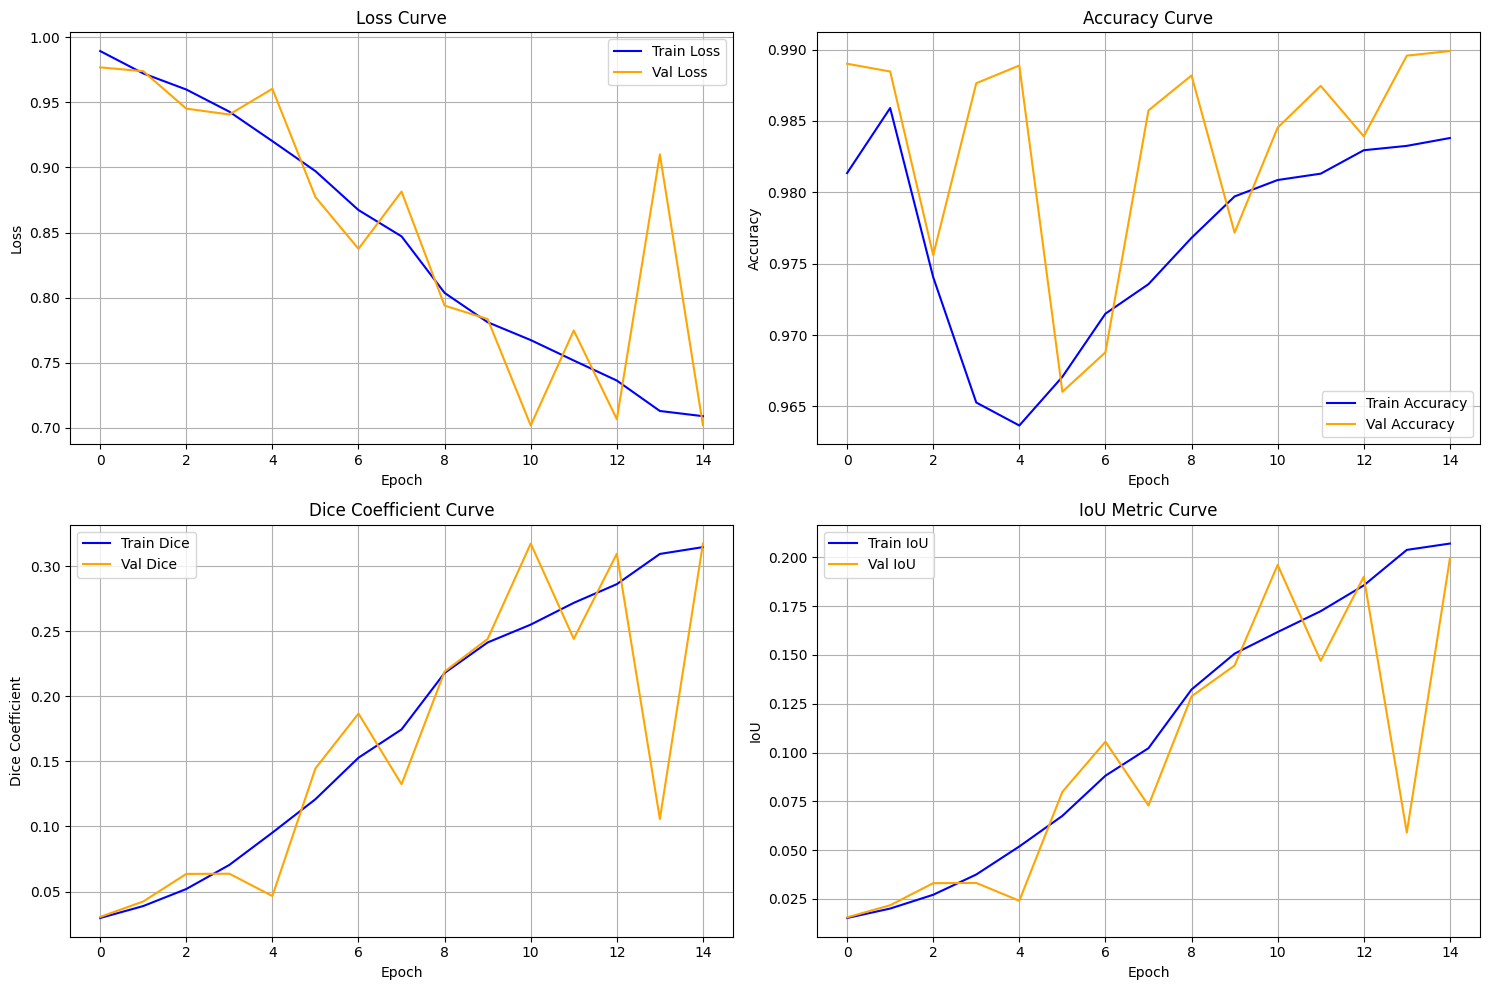

Plotting threshold analysis...


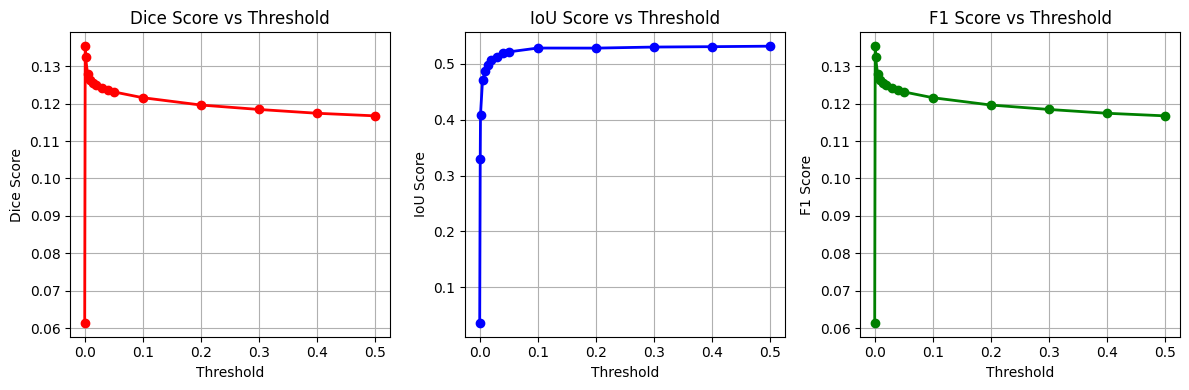

Plotting ROC curve for best threshold...


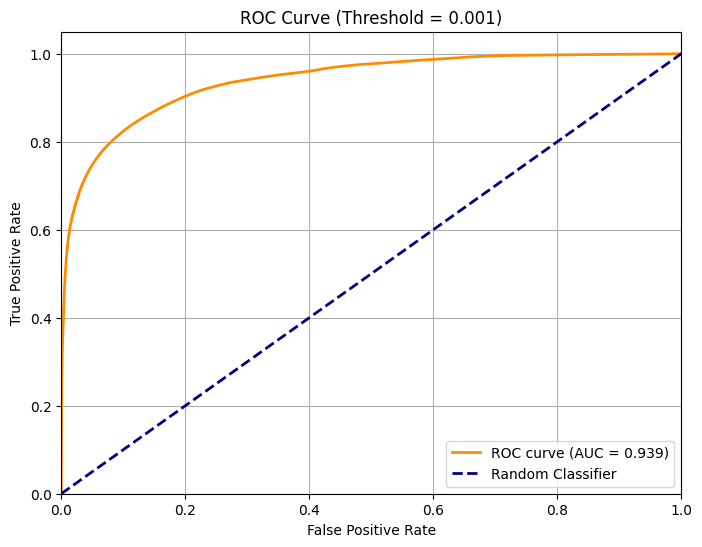


=== FINAL IMPROVED RESULTS ===
Best Threshold: 0.001
Best Dice Score: 0.135
Best IoU Score: 0.329
Best F1 Score: 0.135
ROC AUC: 0.939


In [206]:
# VISUALIZATION AND RESULTS ANALYSIS

# Plot training curves
def plot_training_curves(history):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', color='orange')
    axes[0, 0].set_title('Loss Curve')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
    axes[0, 1].set_title('Accuracy Curve')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Train Dice', color='blue')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Val Dice', color='orange')
    axes[1, 0].set_title('Dice Coefficient Curve')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Coefficient')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # IoU
    axes[1, 1].plot(history.history['iou_metric'], label='Train IoU', color='blue')
    axes[1, 1].plot(history.history['val_iou_metric'], label='Val IoU', color='orange')
    axes[1, 1].set_title('IoU Metric Curve')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('IoU')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot threshold analysis
def plot_threshold_analysis(results):
    """Plot performance metrics across different thresholds"""
    thresholds = list(results.keys())
    dice_scores = [results[t]['dice'] for t in thresholds]
    iou_scores = [results[t]['iou'] for t in thresholds]
    f1_scores = [results[t]['f1'] for t in thresholds]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(thresholds, dice_scores, 'o-', color='red', linewidth=2)
    plt.title('Dice Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Dice Score')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(thresholds, iou_scores, 'o-', color='blue', linewidth=2)
    plt.title('IoU Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('IoU Score')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(thresholds, f1_scores, 'o-', color='green', linewidth=2)
    plt.title('F1 Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ROC Curve for best threshold
def plot_roc_curve(results, threshold):
    """Plot ROC curve for the best threshold"""
    y_true = results[threshold]['y_true']
    y_prob = results[threshold]['y_prob']
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Threshold = {threshold})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return roc_auc

# Generate all visualizations
if 'history_improved' in locals():
    print("Plotting training curves...")
    plot_training_curves(history_improved)

print("Plotting threshold analysis...")
plot_threshold_analysis(evaluation_results)

print("Plotting ROC curve for best threshold...")
roc_auc = plot_roc_curve(evaluation_results, best_threshold)

print(f"\n=== FINAL IMPROVED RESULTS ===")
print(f"Best Threshold: {best_threshold}")
print(f"Best Dice Score: {evaluation_results[best_threshold]['dice']:.3f}")
print(f"Best IoU Score: {evaluation_results[best_threshold]['iou']:.3f}")
print(f"Best F1 Score: {evaluation_results[best_threshold]['f1']:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

## Visualize Actual Image, Ground Truth Annotation, and Predicted Mask

The following cells allow you to input an image name, display the original X-ray, overlay the ground truth annotation (using the existing `draw_annotation` function), and show the predicted mask from the trained model.

## Segmentation Visualization Function

This function provides a comprehensive visualization of segmentation results, including:

1. Original X-ray image
2. Prediction heatmap showing confidence levels
3. Binary mask after thresholding
4. Segmentation overlaid on both resized and original images
5. Ground truth annotation for comparison

This visualization is crucial for qualitatively assessing model performance, understanding error patterns, and communicating results to clinical stakeholders who may not be familiar with quantitative metrics like Dice coefficient or IoU.

In [207]:
def visualize_image_and_segmentation(model, image_name, threshold = 0.5):      
    """
    Visualize the actual X-ray, ground truth annotation, and predicted mask for a given image_name.
    All visualizations are organized in 2 rows of subplots for better comparison.
    Args:
        image_name (str): The filename of the image (e.g., 'IMG000013.jpeg')
    """
    
    import os
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image as PILImage

    # Create figure with 2 rows and 3 columns for all visualizations
    fig = plt.figure(figsize=(18, 12))

    # Show the actual X-ray image
    img_path = os.path.join(IMG_DIR, image_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found.")
        return

    # Store original dimensions for later scaling
    original_height, original_width = img.shape

    # Original image - position (0,0)
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"Original Image: {image_name}")
    ax1.axis('off')

    # Predict mask using the model
    img_rgb = PILImage.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img_rgb) / 255.0
    input_arr = np.expand_dims(img_arr, axis=0)
    pred_mask = model.predict(input_arr)[0].squeeze()

    # Create binary mask with proper threshold
    pred_mask_bin = (pred_mask > threshold).astype(np.uint8)  # Increased threshold for better precision

    # Prediction heatmap - position (0,1)
    ax2 = fig.add_subplot(2, 3, 2)
    heatmap = ax2.imshow(pred_mask, cmap='jet')
    ax2.set_title(f"Prediction Heatmap")
    ax2.axis('off')
    plt.colorbar(heatmap, ax=ax2, fraction=0.046, pad=0.04, label='Confidence')

    # Binary mask - position (0,2)
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(pred_mask_bin, cmap='gray')
    ax3.set_title(f"Binary Mask (threshold={threshold})")
    ax3.axis('off')

    # Find contours in the predicted mask
    pred_mask_uint8 = (pred_mask_bin * 255).astype(np.uint8)
    contours, _ = cv2.findContours(pred_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by size to remove noise
    min_contour_area = 10  # Adjust as needed
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Create visualization on a copy of the model-sized image
    img_viz = np.array(img_rgb).copy()

    # Draw contours and bounding boxes
    for cnt in contours:
        # Draw contour in red with thickness=2 for better visibility
        cv2.drawContours(img_viz, [cnt], -1, (255, 0, 0), 2)

        # Draw bounding box in green
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_viz, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Segmentation on resized image - position (1,0)
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(img_viz)
    ax4.set_title(f"Predicted Segmentation (Resized)")
    ax4.axis('off')

    # Segmentation on original image - position (1,1)
    # Convert contours to original image scale for display on original image
    scale_x = original_width / IMG_SIZE
    scale_y = original_height / IMG_SIZE

    # Create a visualization on the original image
    original_img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for cnt in contours:
        # Scale contour to original image dimensions
        scaled_cnt = cnt.copy()
        scaled_cnt = scaled_cnt.astype(np.float32)
        scaled_cnt[:, :, 0] *= scale_x
        scaled_cnt[:, :, 1] *= scale_y
        scaled_cnt = scaled_cnt.astype(np.int32)

        # Draw scaled contour on original image
        cv2.drawContours(original_img_rgb, [scaled_cnt], -1, (255, 0, 0), 2)

        # Draw scaled bounding box
        x, y, w, h = cv2.boundingRect(cnt)
        x_orig = int(x * scale_x)
        y_orig = int(y * scale_y)
        w_orig = int(w * scale_x)
        h_orig = int(h * scale_y)
        cv2.rectangle(original_img_rgb, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (0, 255, 0), 2)

    ax5 = fig.add_subplot(2, 3, 5)
    ax5.imshow(original_img_rgb)
    ax5.set_title(f"Predicted Segmentation (Original Size)")
    ax5.axis('off')

    # Ground truth annotation - position (1,2)
    image_id_no_ext = os.path.splitext(image_name)[0]
    ann = load_annotation(image_id_no_ext)

    # Create a copy of the original image for ground truth visualization
    gt_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    if ann:
        for shape in ann.get('shapes', []):
            label = shape.get('label', 'tumor')
            pts = shape.get('points', [])
            st = shape.get('shape_type', 'polygon')
            if st == 'rectangle' and len(pts) >= 2:
                x1, y1 = _to_int_tuple(pts[0])
                x2, y2 = _to_int_tuple(pts[1])
                x_min, x_max = min(x1, x2), max(x1, x2)
                y_min, y_max = min(y1, y2), max(y1, y2)
                cv2.rectangle(gt_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
                cv2.putText(gt_img, label, (x_min, max(0, y_min-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            elif st in ('polygon', 'polyline') and len(pts) >= 3:
                polygon = np.array([_to_int_tuple(p) for p in pts], dtype=np.int32).reshape((-1, 1, 2))
                cv2.polylines(gt_img, [polygon], isClosed=True, color=(255, 0, 0), thickness=2)
                cv2.putText(gt_img, label, _to_int_tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(gt_img)
    ax6.set_title(f"Ground Truth Annotation")
    ax6.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


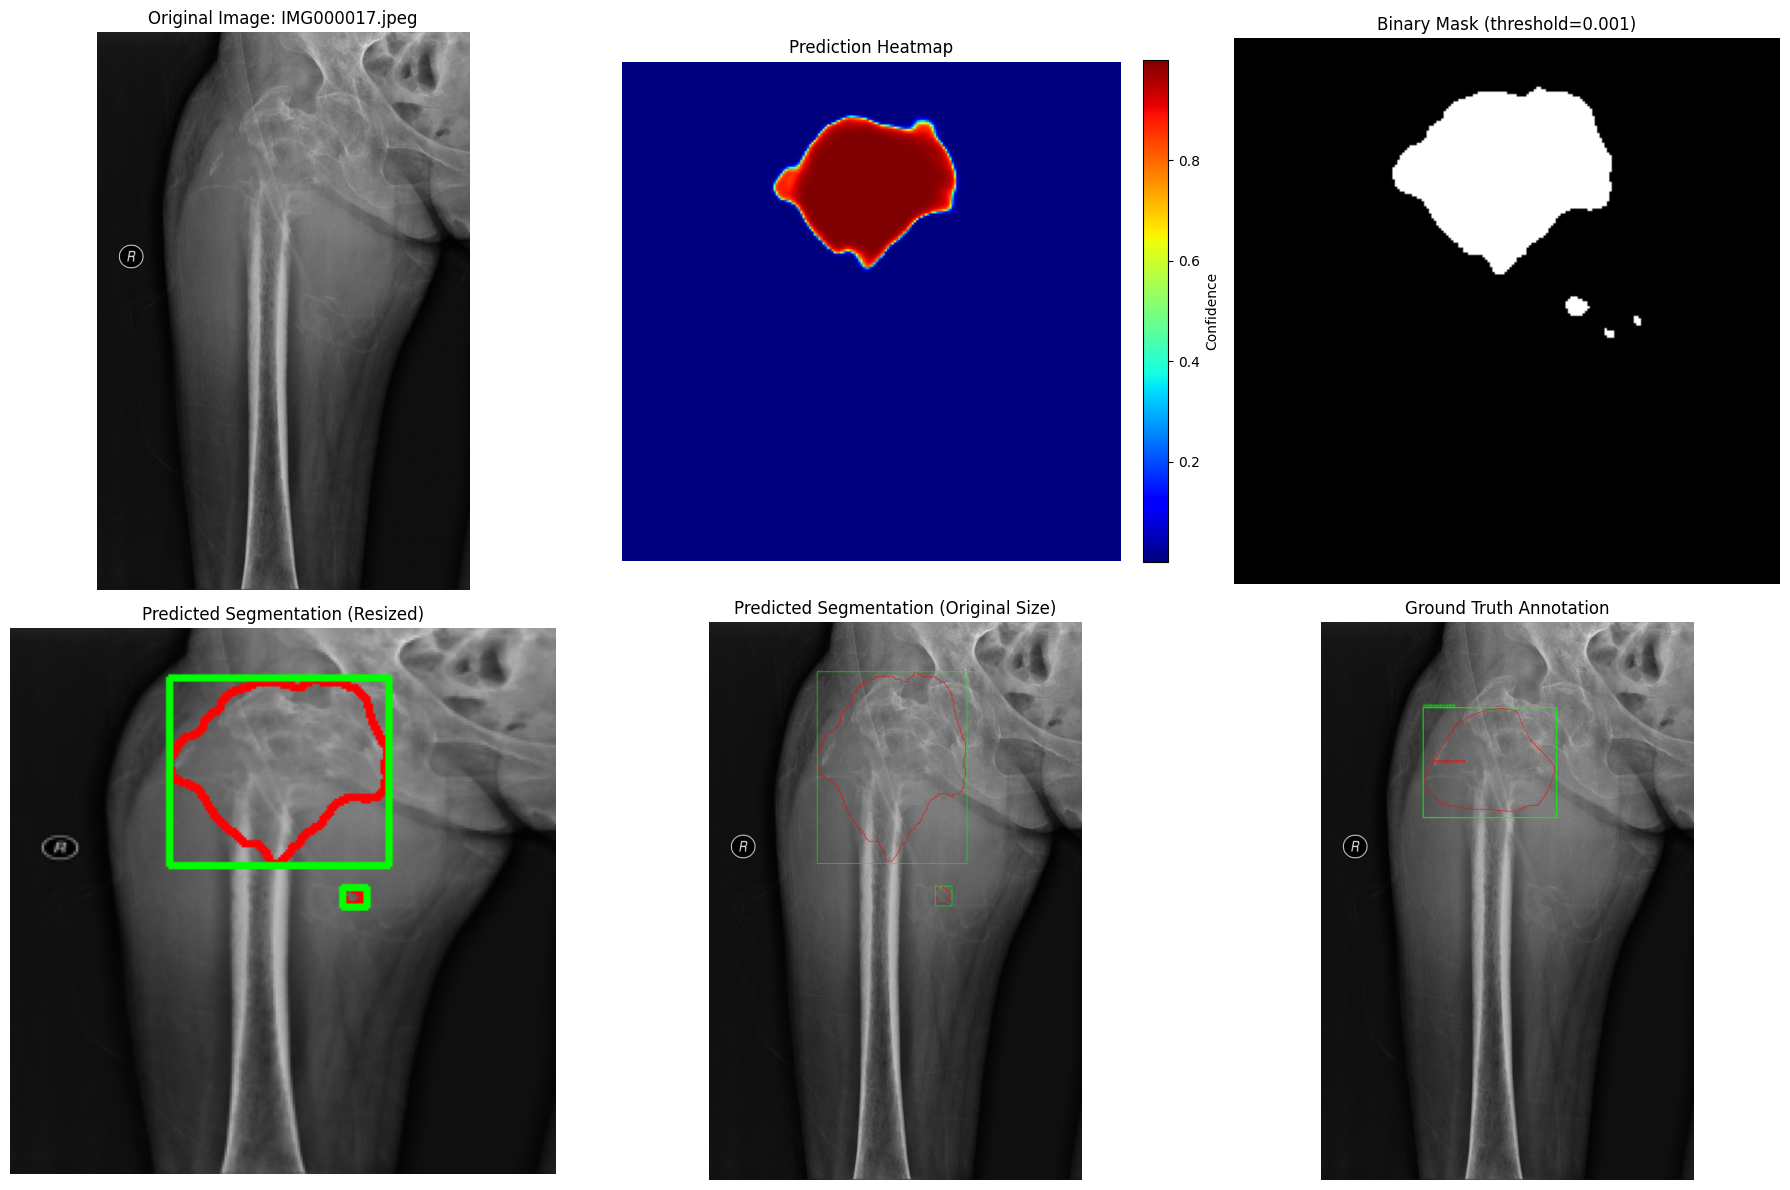

In [215]:
visualize_image_and_segmentation(improved_model, 'IMG000017.jpeg', threshold=0.001)